In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chipotle/chipotle.tsv


In this notebook, I will explore the Chipotle sales data by analyzing and visualizing it with Python. I will follow the steps of taking a quick look as the data first. Then, modify the data a little so that it will be the form that suits our needs for plots and analytics. 

What I want to know from the sales of Chipotles are the price range of every single order, the best and worst selling items, and the popular side choices that come with the order. 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
df = pd.read_table('/kaggle/input/chipotle/chipotle.tsv')

In [4]:
df.head()

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39
1,1,1,Izze,[Clementine],$3.39
2,1,1,Nantucket Nectar,[Apple],$3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98


In [5]:
df.shape

(4622, 5)

As you can see above, the dataset comes with 4,622 rows and 5 columns. Each row represents one item in an order. The columns include order id, quantity of the item, item name, side choice that comes with the item, and the item price. Notice that the item price column is already the total price of that specific item. So, we do not need to multiply quantity with price to get the total price. 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4622 entries, 0 to 4621
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            4622 non-null   int64 
 1   quantity            4622 non-null   int64 
 2   item_name           4622 non-null   object
 3   choice_description  3376 non-null   object
 4   item_price          4622 non-null   object
dtypes: int64(2), object(3)
memory usage: 180.7+ KB


Here we can get the data type of each feature. For the further analysis, we need to change the type of item price from string to numerical.

In [7]:
# get rid of $ sign and convert the column to float
df['item_price'] = df['item_price'].str.split('$').str.get(1)
df['item_price'] = df['item_price'].astype('float')

In [8]:
total_revenue = df['item_price'].sum()
print('The total revenue is ${}'.format(total_revenue))

The total revenue is $34500.16


Add up all the prices to get the total revenue, at least for this small dataset.

# Order Price Range

In [9]:
order_price = df.groupby('order_id')['item_price'].sum().reset_index()
order_price.head()

,order_id,item_price
0,1,11.56
1,2,16.98
2,3,12.67
3,4,21.00
4,5,13.70


I used groupby method to get another dataframe that consists of total price for each order. And below we can see the statistics of the order prices.

In [10]:
print('The highest single order price: ${}'.format(order_price['item_price'].max()))
print('The lowest single order price: ${}'.format(order_price['item_price'].min()))
print('The average single order price: ${:.2f}'.format(order_price['item_price'].mean()))
print('The median of single order price: ${:.2f}'.format(order_price['item_price'].median()))

The highest single order price: $205.25
The lowest single order price: $10.08
The average single order price: $18.81
The median of single order price: $16.20


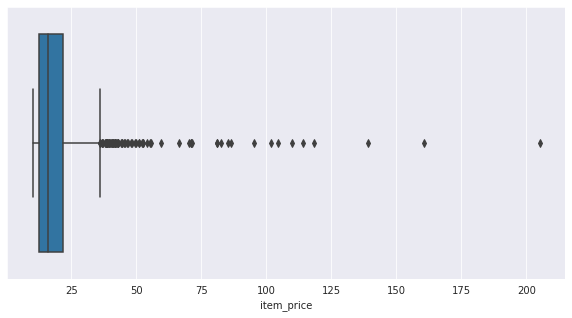

In [11]:
plt.figure(figsize=(10,5))
sns.boxplot(data=order_price, x='item_price');

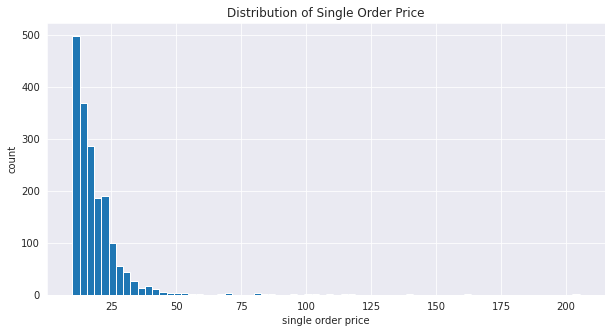

In [12]:
plt.figure(figsize=(10,5));
plt.hist(order_price['item_price'], bins=70);
plt.xlabel('single order price');
plt.ylabel('count');
plt.title('Distribution of Single Order Price');

With the box plot and bar plot above, we know that most orders were in the range of 15 to 30 dollars. Only a few orders exceeded over 50 or even 100 dollars.

# Best and Worst Selling Products

In [13]:
item_quantity = df.groupby('item_name')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

In [14]:
item_quantity.head()

,item_name,quantity
17,Chicken Bowl,761
18,Chicken Burrito,591
25,Chips and Guacamole,506
39,Steak Burrito,386
10,Canned Soft Drink,351


Again, I used groupby to get the total quantity for each item and sort them descendingly.

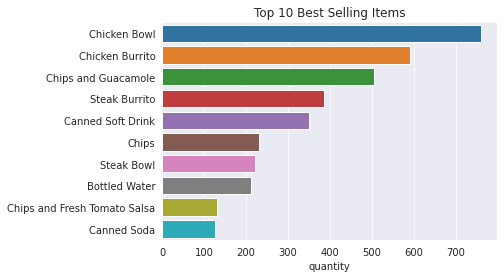

In [15]:
sns.barplot(data=item_quantity.iloc[:10], x='quantity', y='item_name');
plt.title('Top 10 Best Selling Items');
plt.ylabel('');

The most popular item is chicken bowl, which got ordered for more than 700 times.

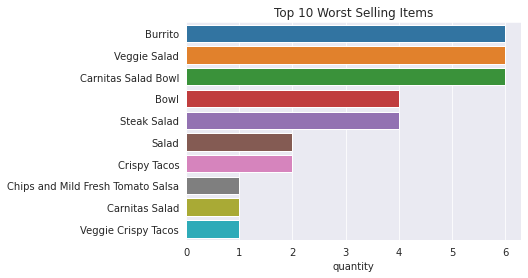

In [16]:
sns.barplot(data=item_quantity.iloc[-10:], x='quantity', y='item_name');
plt.title('Top 10 Worst Selling Items');
plt.ylabel('');

Carnitas salad is the least popular item out there, only got ordered once.

# Most popular side choice for the order of chicken bowl

In [17]:
chicken_bowl = df[df['item_name'] == 'Chicken Bowl']
chicken_bowl.loc[:, 'choice_description'] = chicken_bowl['choice_description'].str.replace('[', '', regex=True)
chicken_bowl.loc[:, 'choice_description'] = chicken_bowl['choice_description'].str.replace(']', '', regex=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Here I want to focus on what sides people tended to choose along with the most popular item chicken bowl. I would like to count the number of occurrances for side choices in chicken bowl to get my answer.

Because the choice_description column is in string type and contains "[" and "]", I first removed them by using replace method. 

In [18]:
chicken_bowl.loc[:, 'choice_description'] = chicken_bowl['choice_description'].str.split(', ')

Then, once choice_description only contains side choices seperated by comma, I splitted them so that each of them is stored in list now.

Finally, a distionary is created to store the occurraces after running a for loop for counting.

In [19]:
choices_dict = {}

for choices in chicken_bowl['choice_description']:
    for choice in choices:
        if choice not in choices_dict:
            choices_dict[choice] = 0
        choices_dict[choice] += 1

choices_dict

{'Tomatillo-Red Chili Salsa (Hot)': 65,
 'Black Beans': 386,
 'Rice': 684,
 'Cheese': 549,
 'Sour Cream': 427,
 'Fresh Tomato Salsa (Mild)': 83,
 'Guacamole': 282,
 'Lettuce': 443,
 'Fresh Tomato Salsa': 324,
 'Fajita Vegetables': 209,
 'Tomatillo Red Chili Salsa': 61,
 'Roasted Chili Corn Salsa (Medium)': 65,
 'Pinto Beans': 120,
 'Fajita Veggies': 87,
 'Roasted Chili Corn Salsa': 106,
 'Tomatillo Green Chili Salsa': 65,
 'Tomatillo-Green Chili Salsa (Medium)': 21,
 'Fresh Tomato (Mild)': 4,
 'White Rice': 2}

In [20]:
choices_df = pd.DataFrame(choices_dict.items(), columns=['choice', 'occurances'])
choices_df = choices_df.sort_values('occurances', ascending=False)

choices_df

,choice,occurances
2,Rice,684
3,Cheese,549
7,Lettuce,443
4,Sour Cream,427
1,Black Beans,386
8,Fresh Tomato Salsa,324
6,Guacamole,282
9,Fajita Vegetables,209
12,Pinto Beans,120
14,Roasted Chili Corn Salsa,106


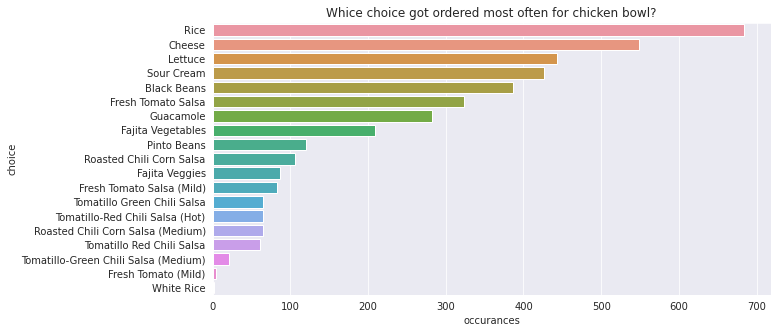

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(data=choices_df, x='occurances', y='choice');
plt.title('Whice choice got ordered most often for chicken bowl?');

plot above shows the number of occurrances descendingly. Rice, cheese, lettuce, sour cream, and black beans were the most popular side choices when people order chicken bowl at chipotle. It might also indicate that for 
Chipotle, these 5 sides should be prepared and stored in inventory more than others so Chiptole always has enough to serve its customers.